In [1]:
import numpy as np
import os, glob
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import analysis_utils as utils
from scipy.optimize import curve_fit

from itertools import groupby

import importlib
import h5py

yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

importlib.reload(utils)

/Users/yuhan/work/nanospheres/impulse_analysis/analysis_notebooks/../analysis_utils.py:433: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx*amp2kev, gauss(xx*amp2kev, *gps_normalized), label=f'{pulseamps[i]} keV (noise), $\sigma$ = {gps_normalized[2]:.1f} keV', color=color)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_notebooks/../analysis_utils.py:435: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx*amp2kev, gauss(xx*amp2kev, *gps_normalized), label=f'{pulseamps[i]} keV, $\sigma$ = {gps_normalized[2]:.1f} keV', color=color)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_notebooks/../analysis_utils.py:440: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx, gauss(xx, *gps[i]), label=f'{pulseamps[i]} keV (noise), $\sigma$ = {gps[i][2]:.1f} keV', color=color)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_notebooks/../analysis_utils.py:442: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx, gauss(xx, *gps[i]), label=f'{pulseamps

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/impulse_analysis/analysis_notebooks/../analysis_utils.py'>

In [2]:
# Use approximate values from a previous sphere
amp2kev = 4881.810673408754
c_mv = 4.872e-08

Weak damping data seems to have a large non-Gaussian tail. Took some data with strong damping (digital gain=60, analog gain=0.07).

In [3]:
folder = r'/Users/yuhan/work/nanospheres/data/dm_data'
dataset = r'20241025_de_0e_5min'
combined_path = os.path.join(folder, dataset, '*.hdf5')
data_files = sorted(glob.glob(combined_path), key=os.path.getmtime)

In [299]:
bins = np.arange(0, 5, 0.01)
bc = 0.5 * (bins[:-1] + bins[1:])

window_length_long = 5000  # 10 ms analysis window
hh_all = np.empty(shape=(len(data_files), 6000, bc.size))
temp_all = np.empty(shape=(len(data_files), 6000))
good_window = np.full(shape=(len(data_files), 6000), fill_value=True)

for i, file in enumerate(data_files):
    print(file)
    
    f = h5py.File(file, "r")
    adc2mv = f['data']['channel_d'].attrs['adc2mv']
    zz = f['data']['channel_d'][:] * adc2mv / 1e3
    
    ee = f['data']['channel_e'][:] * f['data']['channel_e'].attrs['adc2mv'] / 1e3
    dtt = f['data'].attrs['delta_t']
    fs = int(np.ceil(1 / dtt))

    zz_bp = utils.bandpass_filtered(zz, fs, 30000, 100000)

    # Long window
    zz_bp_long = np.reshape(zz_bp, (int(zz_bp.size / window_length_long), window_length_long))
    ee_long = np.reshape(ee, (int(ee.size / window_length_long), window_length_long))

    q1, q2, q3 = np.quantile(ee.flatten(), [0.25, 0.5, 0.75])
    lockin_thr = 1.5 * (q3 - q1)
    
    for j, zz in enumerate(zz_bp_long):
        amp, amp_lp, temp = utils.recon_force(dtt, zz, c_mv)
        hh_all[i, j] = np.histogram(amp_lp[80:-50], bins=bins)[0]
        temp_all[i, j] = temp
        
        # Identify period of poor detection quality
        # by looking for extended period of low signal level
        small_value = np.abs(zz) < 0.03
        groups = []
        length = []
        for k, g in groupby(small_value):
            if k:
                glist = list(g)
                groups.append(glist)
                length.append(len(glist))
        
        if length:
            if (max(length)) > 10:
                good_window[i, j] = False

/Users/yuhan/work/nanospheres/data/dm_data/20241025_de_0e_5min/20241025_de_0e_0.hdf5
/Users/yuhan/work/nanospheres/data/dm_data/20241025_de_0e_5min/20241025_de_0e_1.hdf5
/Users/yuhan/work/nanospheres/data/dm_data/20241025_de_0e_5min/20241025_de_0e_2.hdf5
/Users/yuhan/work/nanospheres/data/dm_data/20241025_de_0e_5min/20241025_de_0e_3.hdf5
/Users/yuhan/work/nanospheres/data/dm_data/20241025_de_0e_5min/20241025_de_0e_4.hdf5


In [300]:
np.sum(good_window)

19471

In [301]:
q1, q2, q3 = np.quantile(temp_all.flatten(), [0.25, 0.5, 0.75])
temp_thr = q2 + 1.5 * (q3 - q1)

hh_cold = hh_all[temp_all < temp_thr]
print(f'Cold data: {np.sum(temp_all < temp_thr) / temp_all.size * 100:.2f}%')

hh_good = hh_all[good_window]
print(f'Good data: {np.sum(good_window) / temp_all.size * 100:.2f}%')

hh_cold_and_good = hh_all[np.logical_and(temp_all < temp_thr, good_window)]
print(f'Cold and good data: {np.sum(np.logical_and(temp_all < temp_thr, good_window))/ temp_all.size * 100:.2f}%')

Cold data: 90.36%
Good data: 64.90%
Cold and good data: 55.26%


<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_89261/3553923755.py:17: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx, utils.gauss(xx, *gp), 'r:', label=f'Gaussian fit, $\sigma$={gp[2]*1000:.1f} (~ keV/c)')


Text(0, 0.5, 'Count')

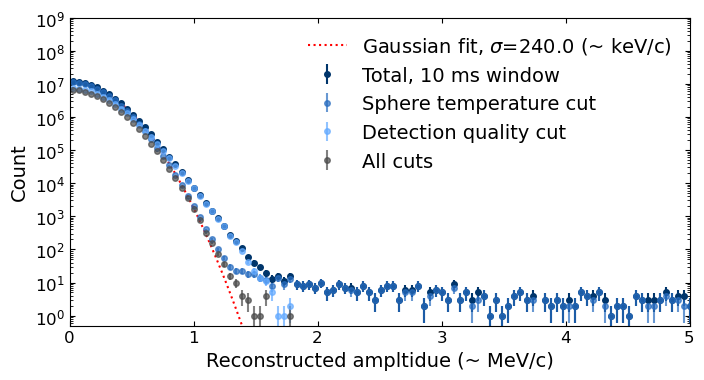

In [302]:
hh_all_sum = np.sum(np.sum(hh_all, axis=0), axis=0)
hh_cold_sum = np.sum(hh_cold, axis=0)
hh_good_sum = np.sum(hh_good, axis=0)
hh_cold_and_good_sum = np.sum(hh_cold_and_good, axis=0)

# Gaussian fit
good_idx = hh_all_sum > 0
gp, gcov = curve_fit(utils.gauss, bc[good_idx]*amp2kev/1000, hh_all_sum[good_idx], p0=[np.max(hh_all_sum), 0, 1], maxfev=10000)

fig, ax = plt.subplots(figsize=(8, 4))
ax.errorbar(bc*amp2kev/1000, hh_all_sum, np.sqrt(hh_all_sum), fmt='o', markersize=4, color=yale_colors[0], label='Total, 10 ms window')
ax.errorbar(bc*amp2kev/1000, hh_cold_sum, np.sqrt(hh_cold_sum), fmt='o', markersize=4, color=yale_colors[1], label='Sphere temperature cut', alpha=0.7)
ax.errorbar(bc*amp2kev/1000, hh_good_sum, np.sqrt(hh_good_sum), fmt='o', markersize=4, color=yale_colors[2], label='Detection quality cut', alpha=0.7)
ax.errorbar(bc*amp2kev/1000, hh_cold_and_good_sum, np.sqrt(hh_cold_and_good_sum), fmt='o', markersize=4, color=yale_colors[3], label='All cuts', alpha=0.7)

xx = np.linspace(0, 2.5, 200)
ax.plot(xx, utils.gauss(xx, *gp), 'r:', label=f'Gaussian fit, $\sigma$={gp[2]*1000:.1f} (~ keV/c)')

ax.set_xlim(0, 5)
ax.set_ylim(0.5, 1e9)
ax.set_yscale('log')
ax.legend(frameon=False, fontsize=14)
ax.set_xlabel('Reconstructed ampltidue (~ MeV/c)')
ax.set_ylabel('Count')

In [303]:
# Find all the files that contribute to the non-gaussian tail
events_idx = []
cold_events_idx = []
cold_and_good_events_idx = []
threshold = 1.5

for i, hh_file in enumerate(hh_all):
    for j, hh in enumerate(hh_file):
        if np.sum(hh[bc*amp2kev/1000 > threshold]) > 0:
            events_idx.append(np.array([i, j]))
            
            if temp_all[i, j] < temp_thr:
                cold_events_idx.append(np.array([i, j]))
                if good_window[i, j]:
                    cold_and_good_events_idx.append(np.array([i, j]))

In [5]:
def plot_hist_events(file_idx, idx):
    file = data_files[file_idx]
    f = h5py.File(file, "r")
    
    zz = f['data']['channel_d'][:] * f['data']['channel_d'].attrs['adc2mv'] / 1e3
    ee = f['data']['channel_e'][:] * f['data']['channel_e'].attrs['adc2mv'] / 1e3
    
    dtt = f['data'].attrs['delta_t']
    fs = int(np.ceil(1 / dtt))

    zz_bp = utils.bandpass_filtered(zz, fs, 30000, 100000)

    # Long window
    zz_bp_long = np.reshape(zz_bp, (int(zz_bp.size / window_length_long), window_length_long))
    
    idx_window = np.full(zz.size, True)
    idx_window[0:window_length_long*idx] = False
    idx_window[window_length_long*(idx+1):] = False

    amp, amp_lp, temp = utils.recon_force(dtt, zz_bp_long[idx], c_mv)
    hh = np.histogram(amp_lp[500:-500], bins=bins)[0]
    
    fig, ax = plt.subplots(1, 3, figsize=(9, 2))
    ax[0].errorbar(bc*amp2kev/1000, hh, np.sqrt(hh), fmt='o', markersize=2)
    ax[0].set_yscale('log')
    ax[0].set_xlim(0, 5)
#     ax[0].set_ylim(1, 5e4)
    ax[0].set_xlabel('Reconstructed amp. (a. u.)', fontsize=12)
    ax[0].set_ylabel('Count', fontsize=12)

    ax[1].plot(dtt*1e6*np.arange(0, amp_lp[80:-50].size), amp_lp[80:-50]*amp2kev/1000, color='grey')
#     ax[1].set_ylim(-5, 5)
    ax[1].set_xlabel('Time ($\mu s$)', fontsize=12)
    ax[1].set_ylabel('Amp. (a. u.)', fontsize=12)
    
    ax[2].plot(dtt*1e6*np.arange(0, zz_bp_long[idx].size), zz_bp_long[idx])
#     ax[2].twinx().plot(dtt*1e6*np.arange(0, zz_bp_long[idx].size), ee[idx_window], 'lightgrey')
    ax[2].set_ylabel('Z homodyne (V)', fontsize=12)
    ax[2].set_xlabel('Time ($\mu s$)', fontsize=12)
    
    fig.suptitle(f'Event (file_{file_idx}, window_{idx})')
    fig.tight_layout()
    
    return amp_lp, hh, zz_bp_long[idx], ee[idx_window], fig, ax

<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_1407/1839066303.py:33: SyntaxWarning: invalid escape sequence '\m'
  ax[1].set_xlabel('Time ($\mu s$)', fontsize=12)
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_1407/1839066303.py:39: SyntaxWarning: invalid escape sequence '\m'
  ax[2].set_xlabel('Time ($\mu s$)', fontsize=12)


For some reason it looks like there's a lot of fake charge jumps. This is likely some electronic noise in the lock-in amplifier when amplitude is close to zero.

/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_89261/2900760492.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 3, figsize=(9, 2))


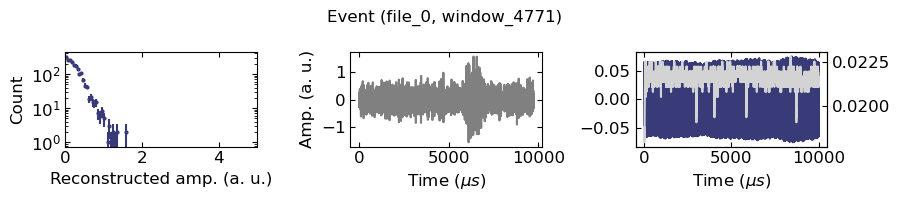

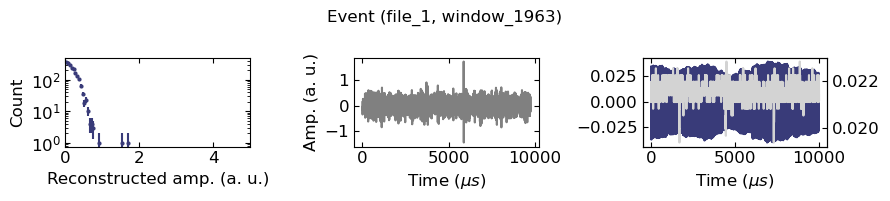

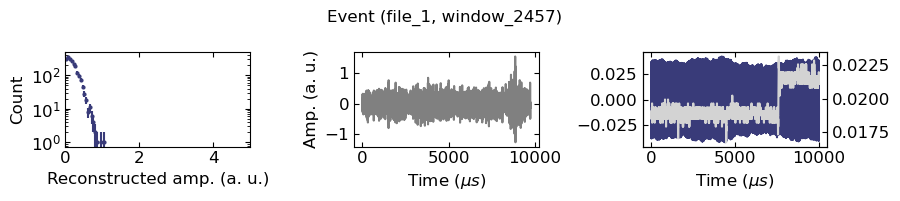

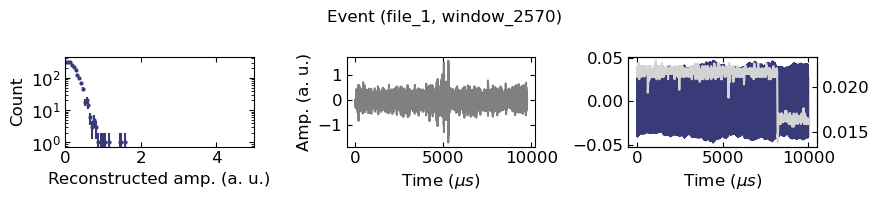

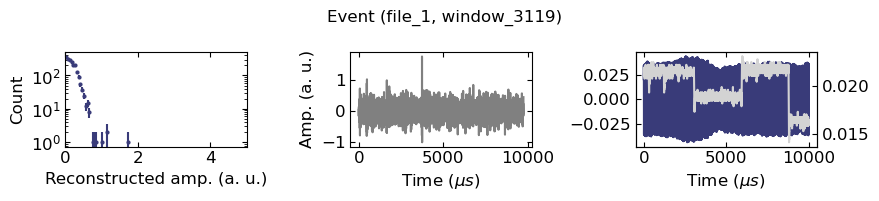

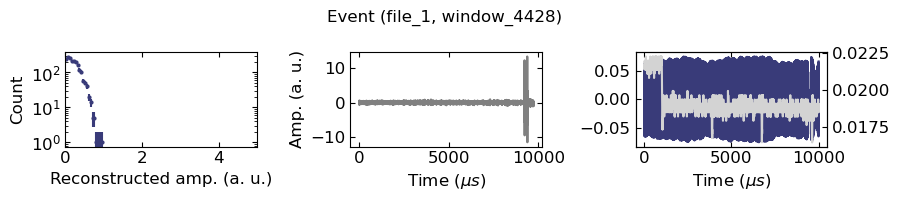

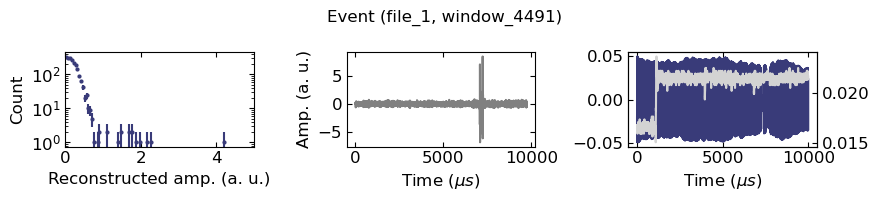

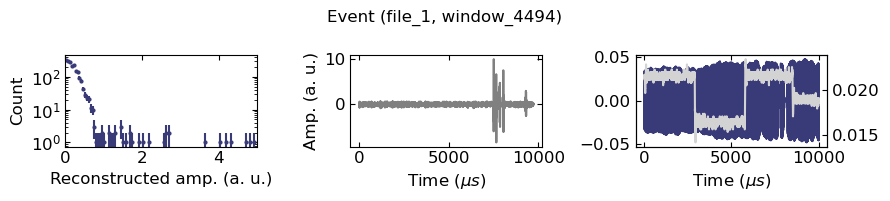

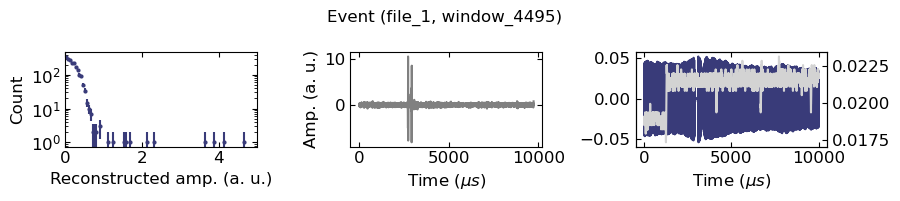

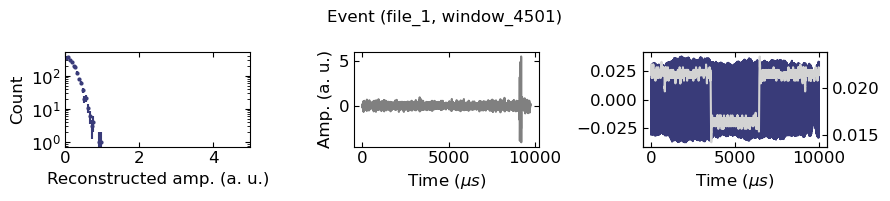

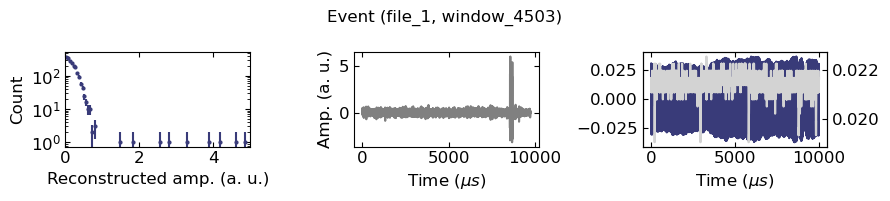

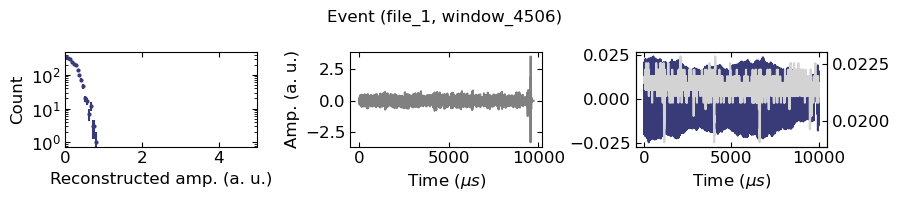

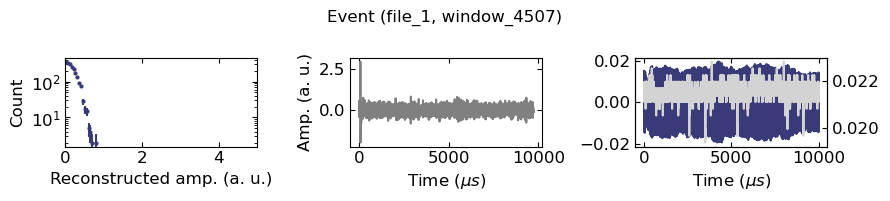

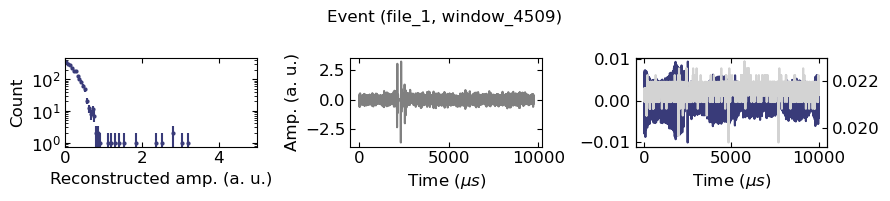

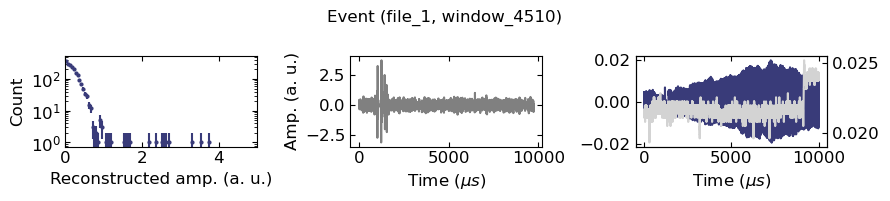

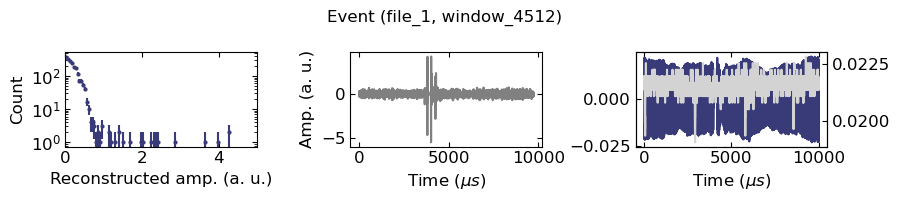

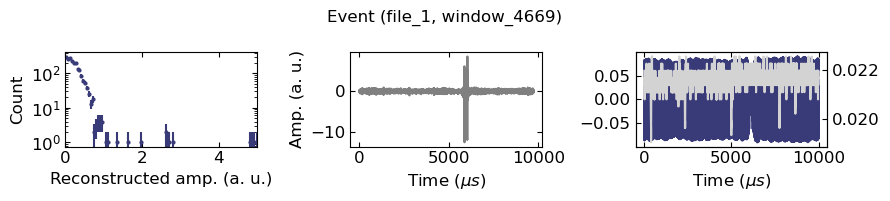

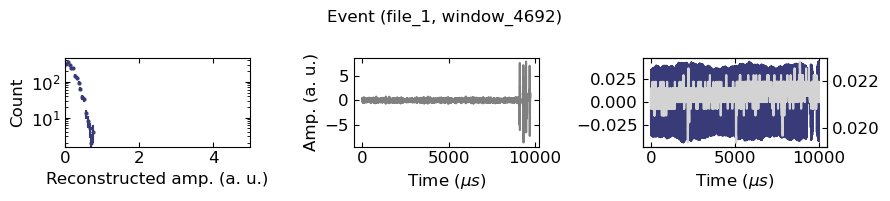

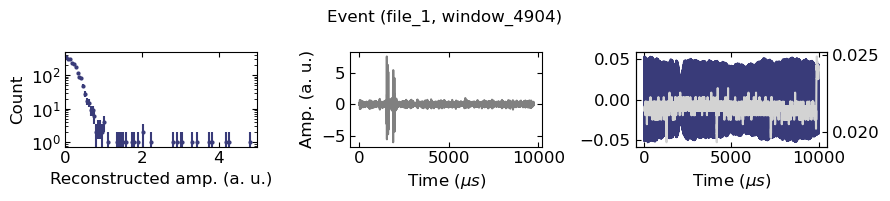

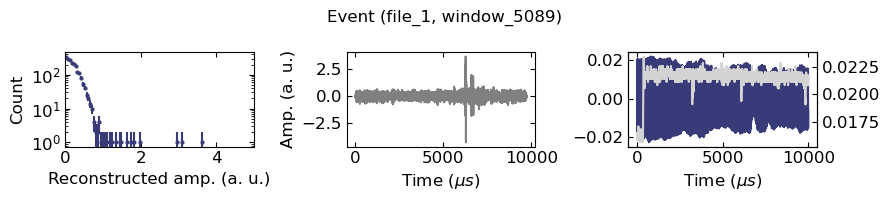

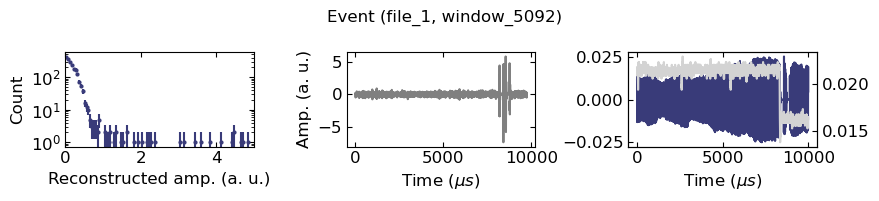

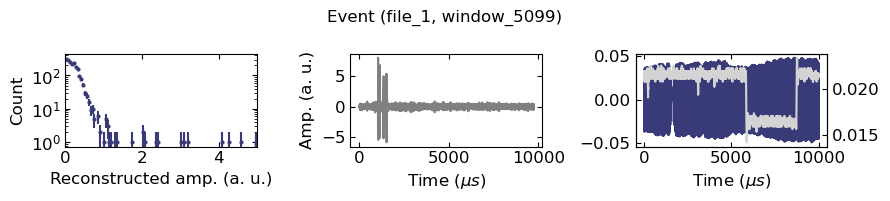

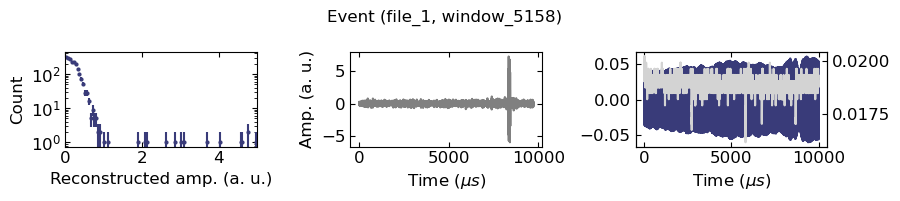

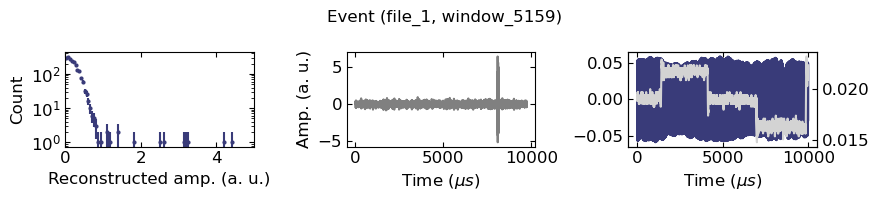

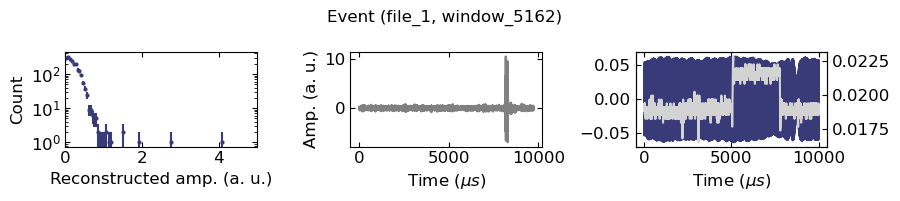

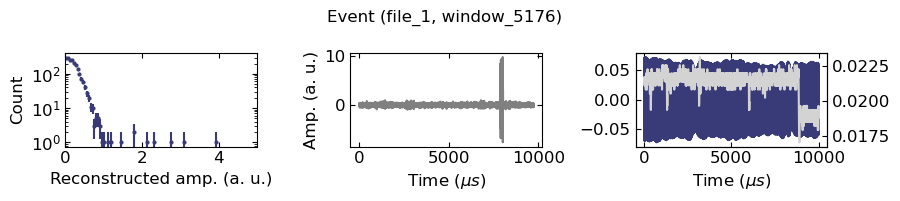

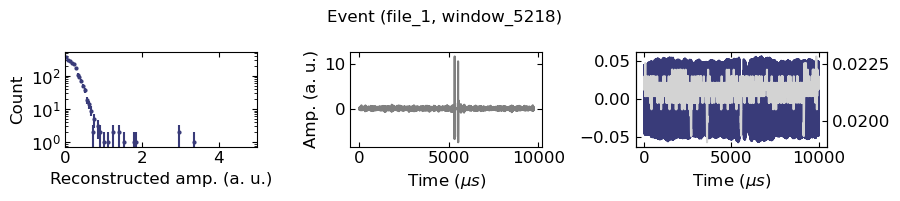

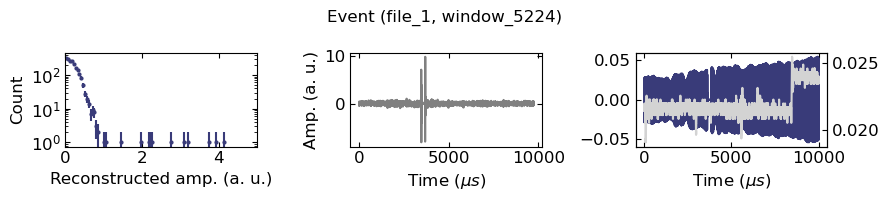

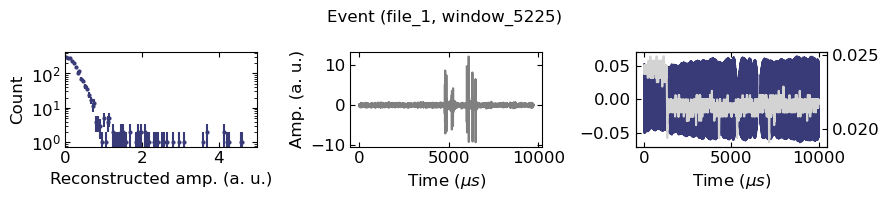

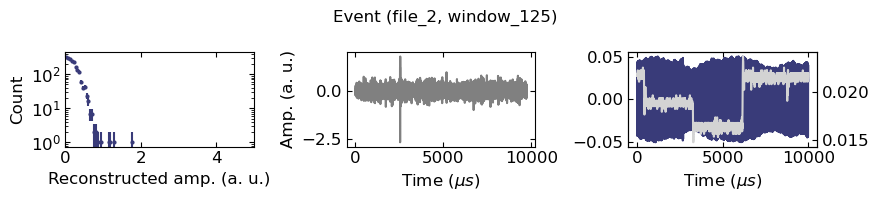

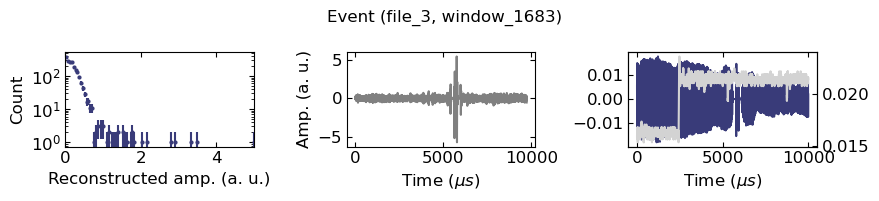

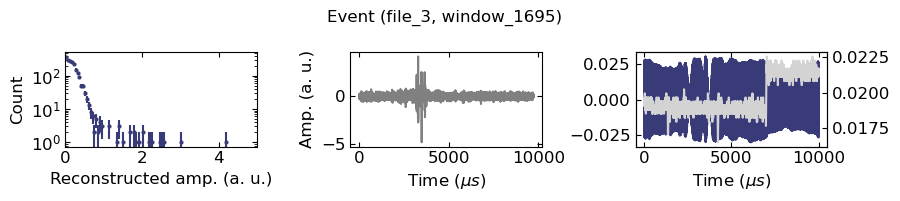

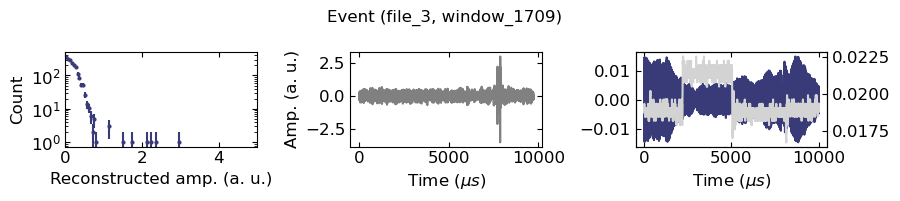

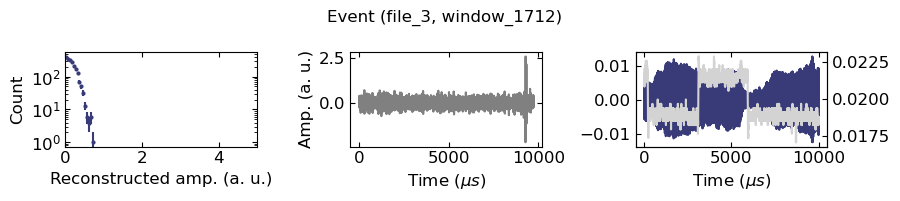

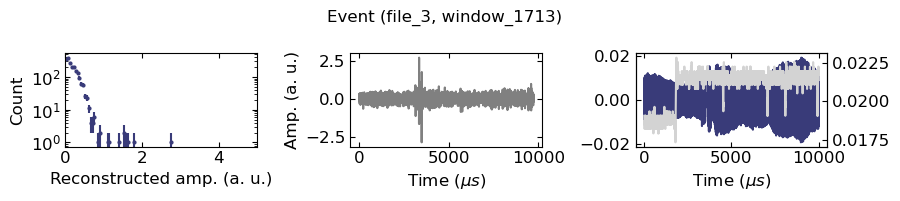

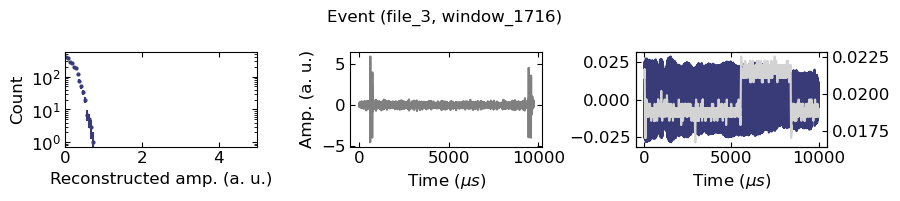

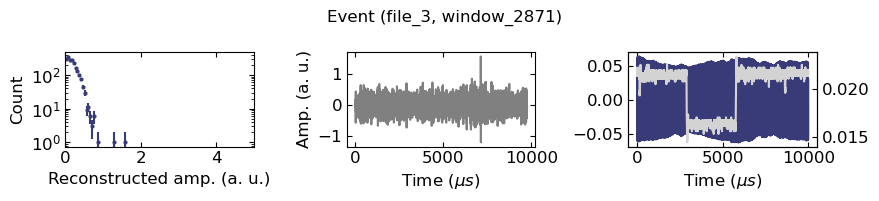

In [175]:
for i, j in cold_events_idx[:]:
    _, _, _, _, _, _ = plot_hist_events(i, j)

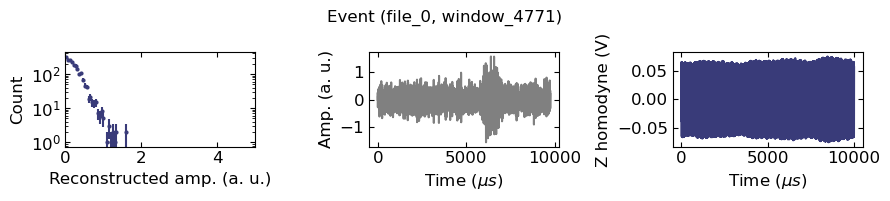

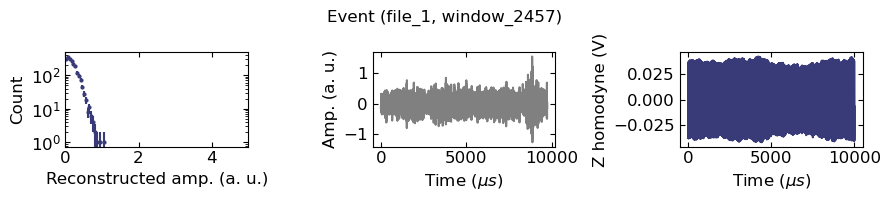

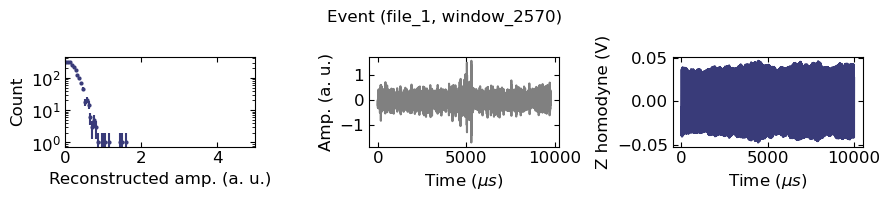

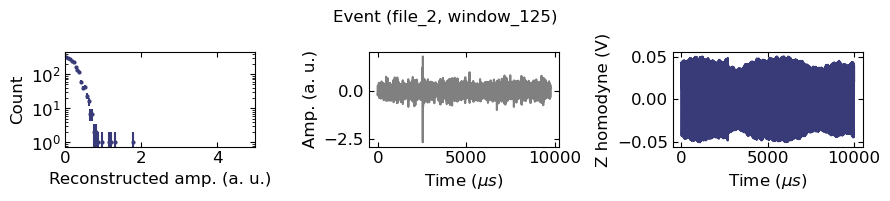

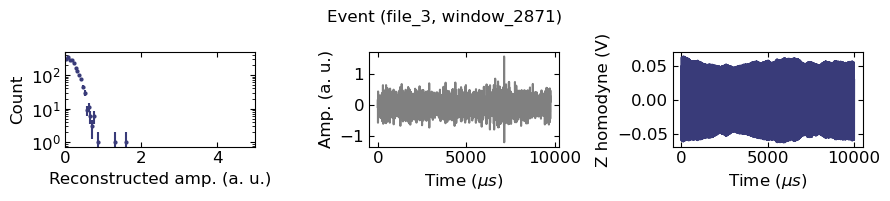

In [304]:
for i, j in cold_and_good_events_idx[:]:
    _, _, _, _, _, _ = plot_hist_events(i, j)

These large events are from backscatter detection not functioning properly. Most likely it's phase locking fails. Try to identify these and cut them away

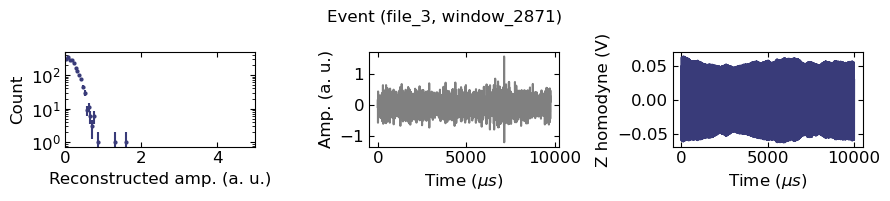

In [306]:
file_idx, idx = 3, 2871
amp_lp, hh, zz_bp, ee, fig, ax = plot_hist_events(file_idx, idx)

(-2.0, 2.0)

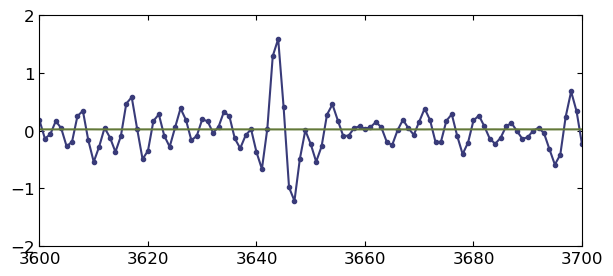

In [308]:
plt.plot(amp_lp*amp2kev/1000, '.-')
plt.plot(ee)
plt.xlim(3600, 3700)
plt.ylim(-2, 2)

(3600.0, 3700.0)

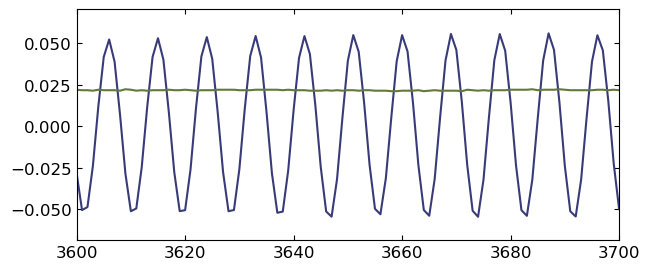

In [281]:
plt.plot(zz_bp)
plt.plot(ee)
plt.xlim(3600, 3700)

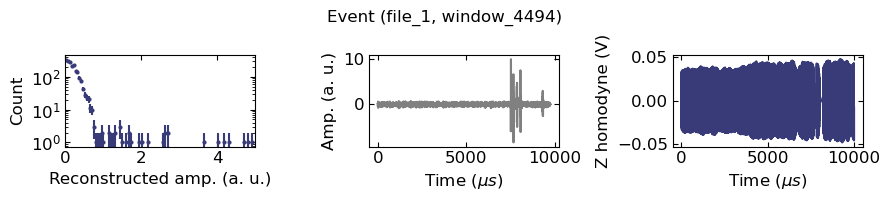

In [8]:
window_length_long = 5000  # 10 ms analysis window
bins = np.arange(0, 5, 0.01)
bc = 0.5 * (bins[:-1] + bins[1:])

file_idx, idx = 1, 4494
amp_lp, hh, zz_bp, ee, fig, ax = plot_hist_events(file_idx, idx)

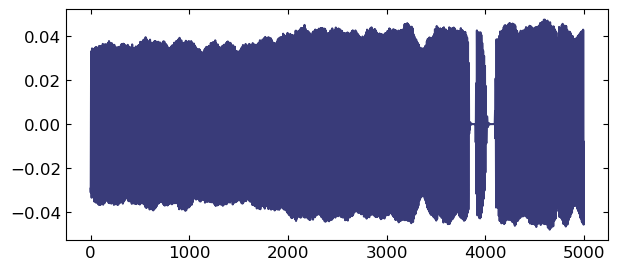

In [9]:
plt.plot(zz_bp)

In [24]:
convolved = np.convolve(np.abs(zz_bp[:5000]),np.ones(10,dtype=int),'valid')

np.sum(convolved < 1e-4)

40